In [1]:
#pip install transformers torch gensim

In [1]:
import pandas as pd
import re
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset,DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AdamW
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.nn.utils.rnn import pad_sequence
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df= pd.read_csv('../data/conversation_dataset.csv')
df.head(2)

,category,conversation,word_count,A_bad_intent,B_bad_intent,description
0,first participant in conversation is deceiving...,"A: Hey, I have something really important to t...",437,1.0,0.0,NaN
1,second participant in conversation is deceivin...,"A: Hey Sarah, I heard you recently went on a t...",368,0.0,1.0,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   category      100 non-null    object 
 1   conversation  100 non-null    object 
 2   word_count    100 non-null    int64  
 3   A_bad_intent  100 non-null    float64
 4   B_bad_intent  100 non-null    float64
 5   description   1 non-null      object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.8+ KB


In [4]:
def text_preprocess(message):
    processed = []   
    for text in message:
        # replaace URLs
        text = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",' <URL>',text)        
        # Remove HTML/XML tags (if any)
        text = re.sub(r'<.*?>', '', text)
        # Remove punctuation and symbols (not for now)
        # text = re.sub(r'[^\w\s]', '', text) 
        # Remove numbers - not in this dataset!
        #text = re.sub(r'\d+', '', text)
        # Remove whitespaces (including new lines and tabs)
        text = text.strip().replace("\n", " ").replace("\r", " ").replace("\t", " ")
        # Replace all non alphabets.
        #text = re.sub("[^a-zA-Z0-9]", " ", text)
        
        processed.append(text)       
    return processed

In [5]:
df['conversation'] = text_preprocess(list(df['conversation']))

In [6]:
df.loc[0]['conversation']

"A: Hey, I have something really important to tell you.  B: Sure, what's up?  A: You know that job opportunity I told you about last month? Well, I got it!  B: Wow, that's amazing news! Congratulations!  A: Thank you! I knew you'd be happy for me. B:ut here's the thing, the company wants me to relocate to another city for this position.  B: Oh, really? That's a big change. Are you considering it?  A: Well, I've been thinking about it, but I'm not entirely sure yet. There are a few things to consider, like the cost of living and leaving my family behind.  B: Of course, those are valid concerns. B:ut if it's a great opportunity, maybe it's worth taking the risk?  A: That's true, but I've been doing some research, and it seems like the company has a lot of internal issues. I'm starting to doubt if it's the right move for me.  B: Oh, really? That's concerning. What kind of issues are you talking about?  A: Well, I've heard rumors that they have financial problems and might even be facing b

In [7]:
df['category'].unique()

array(['first participant in conversation is deceiving the second one',
       'second participant in conversation is deceiving the first one',
       'both participants in conversation are deceiving each other',
       'none of participants in conversation try to deceive the other one'],
      dtype=object)

In [8]:
def category_to_label(j):
    if j == 'first participant in conversation is deceiving the second one':
        return 0
    elif j == 'second participant in conversation is deceiving the first one':
        return 1
    elif j == 'both participants in conversation are deceiving each other':
        return 2
    elif j== 'none of participants in conversation try to deceive the other one':
        return 3      
           
df['labels'] = df.category.apply(category_to_label)
df[['category','labels']]

,category,labels
0,first participant in conversation is deceiving...,0
1,second participant in conversation is deceivin...,1
2,both participants in conversation are deceivin...,2
3,none of participants in conversation try to de...,3
4,first participant in conversation is deceiving...,0
...,...,...
95,none of participants in conversation try to de...,3
96,first participant in conversation is deceiving...,0
97,second participant in conversation is deceivin...,1
98,both participants in conversation are deceivin...,2


<Axes: xlabel='labels', ylabel='count'>

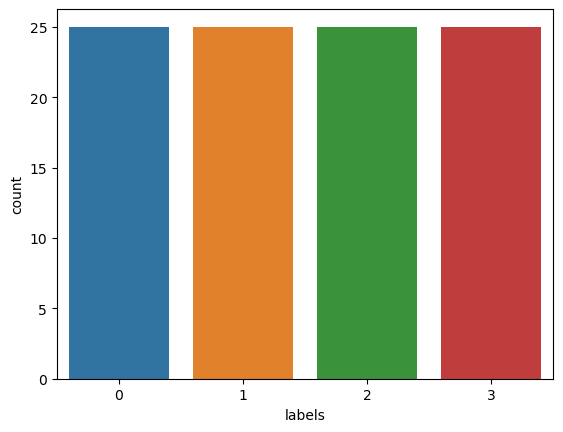

In [9]:
sns.countplot(x =df['labels'])

---
## Classification

In [10]:
# If there's a GPU available...
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU: NVIDIA A100 80GB PCIe MIG 1g.10gb


In [11]:
class ConversationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
 
    def __len__(self):
        return len(self.texts)
 
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        chunks = self.chunk_text(text, self.max_length - 2)  # for special tokens
 
        input_ids = []
        attention_masks = []
 
        for chunk in chunks:
            # Encode each chunk
            inputs = self.tokenizer.encode_plus(chunk, add_special_tokens=True, max_length=self.max_length,
                                                padding='max_length', truncation=True, return_tensors="pt")
            input_ids.append(inputs['input_ids'][0])
            attention_masks.append(inputs['attention_mask'][0])
 
        return {
            'input_ids': torch.stack(input_ids),
            'attention_mask': torch.stack(attention_masks),
            'labels': torch.tensor(label)
        }
 
    def chunk_text(self, text, max_chunk_size):
        # Tokenize the text and chunk it
        tokens = self.tokenizer.tokenize(text)
        chunks = [tokens[i:i + max_chunk_size] for i in range(0, len(tokens), max_chunk_size)]
        return chunks

In [12]:
def create_dataloader(df, tokenizer,batch_size=8 ):
    train_texts, val_texts, train_labels, val_labels = train_test_split(list(df['conversation']), list(df['labels']), test_size=0.3)
 
    train_dataset = ConversationDataset(train_texts, train_labels, tokenizer)
    val_dataset = ConversationDataset(val_texts, val_labels, tokenizer)
    
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
    return train_loader , val_loader

In [13]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = torch.tensor([item['labels'] for item in batch])
 
    # Pad the sequences for each conversation
    input_ids_padded = [pad_sequence(seq, batch_first=True, padding_value=0) for seq in input_ids]
    attention_masks_padded = [pad_sequence(seq, batch_first=True, padding_value=0) for seq in attention_masks]
 
    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'labels': labels
    }

In [14]:
def process_dataloader(model, dataloader, optimizer, device, is_training):
    if is_training:
        model.train()
    else:
        model.eval()
 
    total_loss = 0
    true_labels, predictions = [], []
 
    for batch in dataloader:
        labels = batch['labels'].to(device)
        batch_loss = 0
        conversation_logits = []  # store logits for each conversation
 
        for i in range(len(batch['input_ids'])):
            input_ids_chunks = batch['input_ids'][i].to(device)
            attention_mask_chunks = batch['attention_mask'][i].to(device)
            conversation_labels = labels[i].unsqueeze(0).to(device)
 
            for j in range(input_ids_chunks.size(0)):
                input_ids = input_ids_chunks[j].unsqueeze(0)  # add batch dimension
                attention_mask = attention_mask_chunks[j].unsqueeze(0)  # add batch dimension
 
                if is_training:
                    optimizer.zero_grad()
 
                with torch.set_grad_enabled(is_training):
                    outputs = model(input_ids, attention_mask=attention_mask, labels=conversation_labels)
                    #for models from the transformers library with built-in loss calculation,only need to ensure that
                    #the labels are passed to the model during the forward pass, and model will handle the loss calculation
                    loss = outputs.loss
 
                    if is_training:
                        loss.backward()
                        optimizer.step()
 
                batch_loss += loss.item()
                conversation_logits.append(outputs.logits.detach().cpu())
 
            # aalculate average logits across chunks for a conversation
            avg_logits = torch.mean(torch.stack(conversation_logits), dim=0)
            true_labels.extend(conversation_labels.cpu().numpy())
            predictions.extend(torch.argmax(avg_logits, dim=1).numpy())
 
        
        #The labels are repeated for each chunk of a conversation, where the label applies to the entire conversation
        #(not individual chunks),
        #the loss calculation and accuracy measurements must be adjusted accordingly.
        # normalize the loss by the number of conversations
        total_loss += batch_loss / len(batch['input_ids'])
 
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
 
    return avg_loss, accuracy, f1

In [15]:
def train_model(model, optimizer, train_loader, val_loader,epochs, plot_name=''):
    train_losses, train_accuracies, train_f1_scores = [], [], []
    val_losses, val_accuracies, val_f1_scores = [], [], []
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}:')
        train_loss, train_acc, train_f1 = process_dataloader(model, train_loader, optimizer, device, is_training=True)
        print(f'Train Loss: {train_loss}, Train Accuracy: {train_acc}, Train F1 Score: {train_f1}')
        val_loss, val_acc, val_f1 = process_dataloader(model, val_loader, None, device, is_training=False)
        print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}, Validation F1 Score: {val_f1}')

        # append metrics to their respective lists for plotting later
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1_scores.append(train_f1)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)
        
    if plot_name:
        plot_mode_performance(train_losses , val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores, plot_name )

In [16]:
def plot_mode_performance(train_losses , val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores, name ):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
 
    # training and validation loss
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_title('Loss over Epochs')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # training and validation accuracy
    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(val_accuracies, label='Validation Accuracy')
    axs[1].set_title('Accuracy over Epochs')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # training and validation F1 score
    axs[2].plot(train_f1_scores, label='Train F1 Score')
    axs[2].plot(val_f1_scores, label='Validation F1 Score')
    axs[2].set_title('F1 Score over Epochs')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('F1 Score')
    axs[2].legend()
    
    # add title for plot

    plt.tight_layout()
    plt.savefig(f'{name}.png', dpi=300, bbox_inches='tight')
    plt.show()

---
### 1. BERT

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=4)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [18]:
optimizer = AdamW(model.parameters(), lr=3e-5) 
#also add a scheduler 

In [19]:
train_loader , val_loader = create_dataloader(df, tokenizer)

Epoch 1:
Train Loss: 2.99323510930494, Train Accuracy: 0.2, Train F1 Score: 0.18940167880017503
Validation Loss: 2.6376925396422544, Validation Accuracy: 0.3, Validation F1 Score: 0.13846153846153844
Epoch 2:
Train Loss: 2.8602291287647352, Train Accuracy: 0.22857142857142856, Train F1 Score: 0.22693877551020408
Validation Loss: 2.721058381100496, Validation Accuracy: 0.26666666666666666, Validation F1 Score: 0.11228070175438597
Epoch 3:
Train Loss: 2.8300281260852462, Train Accuracy: 0.22857142857142856, Train F1 Score: 0.16100981767180922
Validation Loss: 2.70508806904157, Validation Accuracy: 0.3, Validation F1 Score: 0.13846153846153844


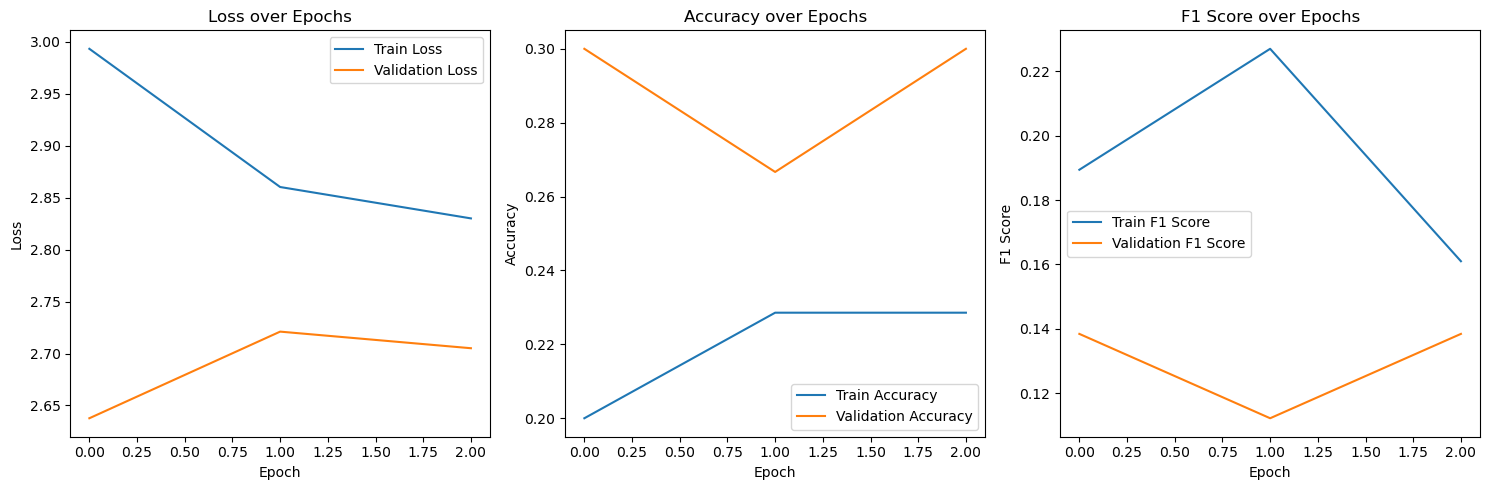

In [20]:
train_model(model, optimizer, train_loader, val_loader, 3,'Multiclass-BERT')

---
### 3. RoBERTa

In [21]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)
model.to(device)
train_loader , val_loader = create_dataloader(df, tokenizer)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:
Train Loss: 2.737319082297661, Train Accuracy: 0.3, Train F1 Score: 0.2171195652173913
Validation Loss: 2.8311988140145936, Validation Accuracy: 0.23333333333333334, Validation F1 Score: 0.08828828828828827
Epoch 2:
Train Loss: 2.6576731431263467, Train Accuracy: 0.3, Train F1 Score: 0.27086302713305005
Validation Loss: 3.023423803349336, Validation Accuracy: 0.1, Validation F1 Score: 0.01818181818181818


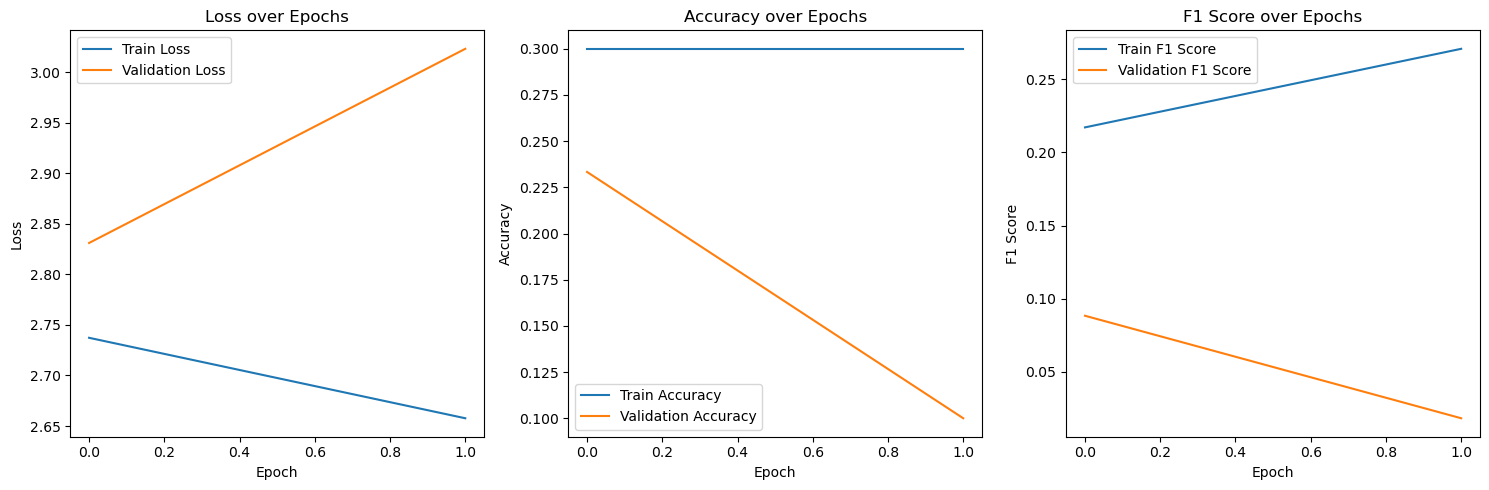

In [22]:
optimizer = AdamW(model.parameters(), lr=2e-5) 
train_model(model, optimizer, train_loader, val_loader, 2,'Multiclass-RoBERTa')

---
### 2. DistilBert

In [23]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=4)
model.to(device)
train_loader , val_loader = create_dataloader(df, tokenizer, 16)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
optimizer = AdamW(model.parameters(), lr=2e-5) 

Epoch 1:
Train Loss: 2.7561098830153545, Train Accuracy: 0.2, Train F1 Score: 0.15614427589217503
Validation Loss: 2.602243009954691, Validation Accuracy: 0.26666666666666666, Validation F1 Score: 0.11228070175438597
Epoch 2:
Train Loss: 2.318600458279252, Train Accuracy: 0.3, Train F1 Score: 0.28389839252182164
Validation Loss: 2.2597508571509803, Validation Accuracy: 0.3, Validation F1 Score: 0.1703703703703704
Epoch 3:
Train Loss: 1.3122035630978643, Train Accuracy: 0.37142857142857144, Train F1 Score: 0.353808210027055
Validation Loss: 1.5231690637966884, Validation Accuracy: 0.3333333333333333, Validation F1 Score: 0.29380116959064323


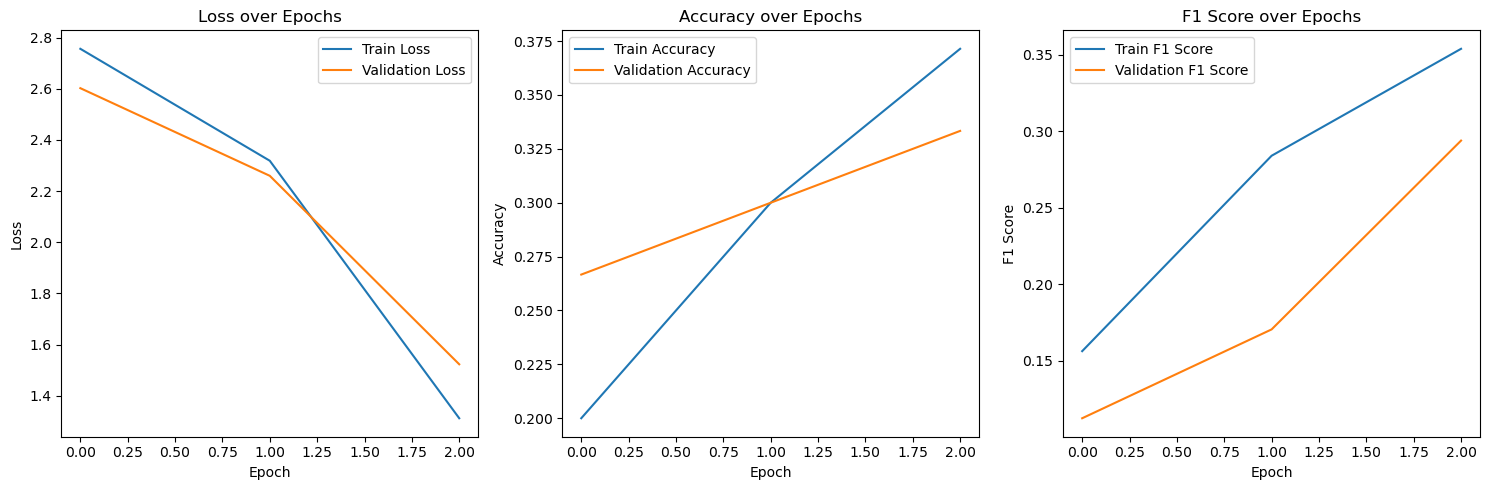

In [25]:
train_model(model, optimizer, train_loader, val_loader, 3,'Multiclass-DistilBERT')

---
### 4.LSTM

---
### 5.Word2vec and classifiers

In [26]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
    return np.mean(word2vec_model.wv[doc], axis=0)

In [27]:
models = {'LogisticRegression' :LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1) ,
          'LinearSVC' : LinearSVC(C = 2),
          'BernoulliNB' : BernoulliNB(alpha = 2),
          'GaussianNB' : GaussianNB()
         }                             

In [28]:
tokenized_conversations = [simple_preprocess(doc) for doc in df.conversation]
# train a Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_conversations, vector_size=100, window=5, min_count=1, workers=4)

In [29]:
conversation_vectors = np.vstack([document_vector(word2vec_model, doc) for doc in tokenized_conversations])

In [30]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df.labels)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(conversation_vectors, labels, test_size=0.2, random_state=42)

In [32]:
accuracies  = {}
f1s = {}
precisions = {}
recalls = {}
# embeddings and df_features dictionaries have the same keys 
for name, model in models.items():
    #print(f'Model: {name} ')
    model.fit(X_train, y_train)
    # evaluate the model
    y_pred = model.predict(X_test)
    accuracies.update({name : accuracy_score(y_test, y_pred)})
    precisions.update({name: precision_score(y_test, y_pred,  average='weighted')})
    recalls.update({name: recall_score(y_test, y_pred,  average='weighted')})
    f1s.update({name: f1_score(y_test, y_pred, average='weighted') })

In [33]:
accuracies

{'LogisticRegression': 0.3,
 'LinearSVC': 0.3,
 'BernoulliNB': 0.15,
 'GaussianNB': 0.35}

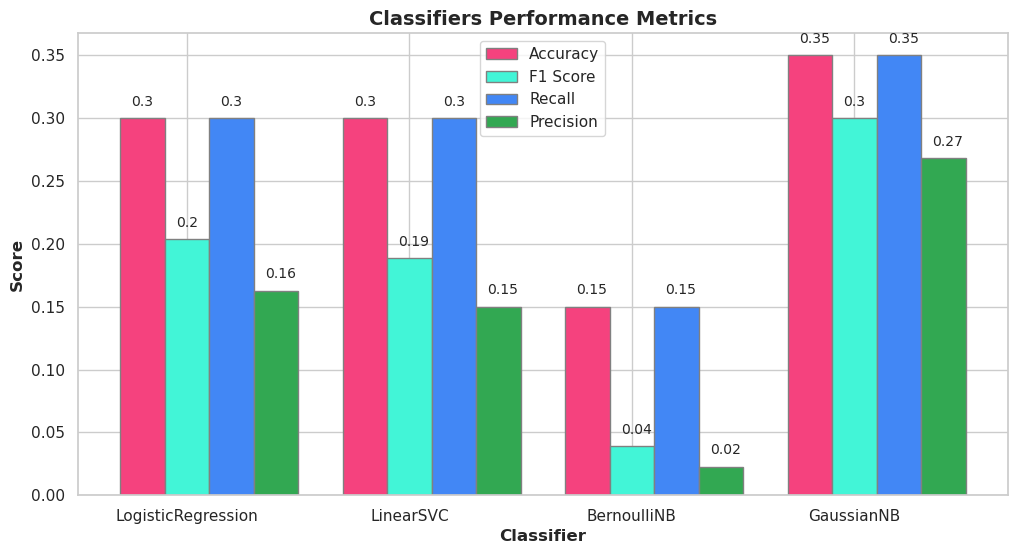

In [34]:
sns.set(style="whitegrid")
# names of classifiers
classifiers = list(f1s.keys())
 # scores
accuracy =  [accuracies[clf] for clf in classifiers]    
f1 = [f1s[clf] for clf in classifiers]
recall = [recalls[clf] for clf in classifiers]
precision = [precisions[clf] for clf in classifiers]

# position of bar on X axis
barWidth = 0.2
r1 = np.arange(len(f1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3] 

plt.figure(figsize=(12, 6))

plt.bar(r1, accuracy, color='#f5427e', width=barWidth, edgecolor='grey', label='Accuracy')
plt.bar(r2, f1, color='#42f5d7', width=barWidth, edgecolor='grey', label='F1 Score')
plt.bar(r3, recall, color='#4287f5', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r4, precision, color='#32a852', width=barWidth, edgecolor='grey', label='Precision')
 
# xticks on the middle of the group bars
plt.xlabel('Classifier', fontweight='bold', fontsize=12)
plt.xticks([r + barWidth for r in range(len(f1))], classifiers)
plt.legend()
plt.title('Classifiers Performance Metrics', fontweight='bold', fontsize=14)
plt.ylabel('Score', fontweight='bold', fontsize=12)
 
# data labels
for i in range(len(r1)):
    plt.text(x = r1[i] - 0.05 , y = accuracy[i] + 0.01, s = round(accuracy[i],2), size = 10)
    plt.text(x = r2[i] - 0.05 , y = f1[i] + 0.01, s = round(f1[i],2), size = 10)
    plt.text(x = r3[i] - 0.05 , y = recall[i] + 0.01, s = round(recall[i],2), size = 10)
    plt.text(x = r4[i] - 0.05 , y = precision[i] + 0.01, s = round(precision[i],2), size = 10)

plt.savefig(f'Multiclass-Word2vec.png', dpi=300, bbox_inches='tight')
plt.show()

---
### 6. DistilBert Embeddings and classifiers

In [35]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=4)
model.to(device)
train_loader , val_loader = create_dataloader(df, tokenizer, 1)
optimizer = AdamW(model.parameters(), lr=3e-5) 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
# extract DistilBERT embedding from its last hidden layer
torch.cuda.empty_cache()
embeddings = []
for batch in train_loader: 
    for i in range(len(batch['input_ids'])): 
        print('i', i)
        input_ids_chunks = batch['input_ids'][i].to(device)
        attention_mask_chunks = batch['attention_mask'][i].to(device)
        for j in range(input_ids_chunks.size(0)):
            input_ids = input_ids_chunks[j].unsqueeze(0)  # add batch dimension
            attention_mask = attention_mask_chunks[j].unsqueeze(0)  # add batch dimension
            output = model(input_ids, attention_mask=attention_mask)
            print('Append embeddings...')
            # Typically,  the output of the last hidden layer are considered as the embedding
            # output[0] corresponds to the last hidden state
            embedding = output[0].mean(1)  # mean pooling over the sequence dimension
            embeddings.append(embedding)
            
            
###### CUDA out of memory

i 0
Append embeddings...
Append embeddings...
i 0
Append embeddings...
Append embeddings...
i 0
Append embeddings...
Append embeddings...
i 0
Append embeddings...
Append embeddings...
i 0
Append embeddings...
Append embeddings...
i 0
Append embeddings...
i 0
Append embeddings...
Append embeddings...
i 0
Append embeddings...
Append embeddings...
i 0
Append embeddings...
Append embeddings...
i 0
Append embeddings...
Append embeddings...
i 0
Append embeddings...
Append embeddings...
i 0
Append embeddings...
Append embeddings...
i 0


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 9.50 GiB total capacity; 6.07 GiB already allocated; 2.94 MiB free; 6.08 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
embeddings = torch.stack(embeddings)  # convert list of tensors to a tensor
labels = torch.tensor(labels)  # convert labels list to a tensor
dataset = TensorDataset(embeddings, labels)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

#### 6.1 LSTM

In [ ]:
# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
 
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # get the output of the last time step
        out = self.fc(lstm_out)
        return out
 
model = LSTMClassifier(embedding_dim=embeddings.size(-1), hidden_dim=128, output_dim=num_classes)
model.to(device)
 
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1s = []
val_f1s = []
num_epochs = 10 
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss, total_acc, total_f1 = 0, 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_acc += (predicted == targets).sum().item()
        total_f1 += f1_score(targets.cpu(), predicted.cpu(), average='macro')
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(total_acc / len(train_loader.dataset))
    train_f1s.append(total_f1 / len(train_loader))
 
    # Validation phase
    model.eval()
    total_loss, total_acc, total_f1 = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_acc += (predicted == targets).sum().item()
            total_f1 += f1_score(targets.cpu(), predicted.cpu(), average='macro')
 
    val_losses.append(total_loss / len(val_loader))
    val_accuracies.append(total_acc / len(val_loader.dataset))
    val_f1s.append(total_f1 / len(val_loader)

In [ ]:
# Plotting
epochs = range(1, num_epochs + 1)
 
plt.figure(figsize=(12, 4))
 
# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
 
# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
 
# F1 Score Plot
plt.subplot(1, 3, 3)
plt.plot(epochs, train_f1s, 'b', label='Training F1 Score')
plt.plot(epochs, val_f1s, 'r', label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
 
plt.tight_layout()
plt.show()

#### 6.2 CNN

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=5)
        self.fc = nn.Linear(128, num_classes)
 
    def forward(self, x):
        x = x.permute(0, 2, 1)  # conv1d expects (batch, channels, sequence length)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x
 
model = CNNClassifier(embedding_dim=embeddings.size(-1), num_classes=num_classes)
model.to(device)
 
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
train_losses, train_accuracies = [], []
 
for epoch in range(num_epochs):
    model.train()
    total_loss, total_acc = 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_acc += (predicted == targets).sum().item()
    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader.dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(avg_acc)
 
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}')

In [ ]:
epochs = range(1, num_epochs + 1)
 
plt.figure(figsize=(10, 4))
 
# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
 
# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
 
plt.tight_layout()
plt.show()